In [33]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import numpy as np
import statsmodels.api as sm
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [118]:
# Load all the data
dir = "/Users/gustxsr/Documents/Stanford/PoldrackLab/PAPERS/paper1_loss_aversion_pupil/eye_data/NARPS_MG_asc_processed"
pupil_data = []

for file in os.listdir(dir):
    if file.endswith("timeseries_response.csv"):
        csv = pd.read_csv(os.path.join(dir, file))
        pupil_data.append(csv)

pupil_data = pd.concat(pupil_data)

In [3]:
pupil_data["sub_trial"] = pupil_data["sub"].astype(str) + "_" + pupil_data["trial"].astype(str)

In [4]:
# find sub_trial with nan values in ps_preprocessed
# These are the trials in the beginning of the runs. 
nan_sub_trial = pupil_data[pupil_data["ps_preprocessed"].isna()]["sub_trial"].unique()

In [5]:
# remove sub_trial with nan values in ps_preprocessed
pupil_data = pupil_data[~pupil_data["sub_trial"].isin(nan_sub_trial)]

In [6]:
# replace all nan in outofbounds with 0
pupil_data["outofbounds"] = pupil_data["outofbounds"].fillna(0)

In [7]:
behav = pd.read_csv("../../data/behavioral_data.csv")

In [8]:
# Merge behav and pupil_data
data = pupil_data.merge(behav, on=["sub", "trial"])
# remove RT < 0.2 and response_int.isna()
data = data.query("RT > 0.2 & response_int.notna()")

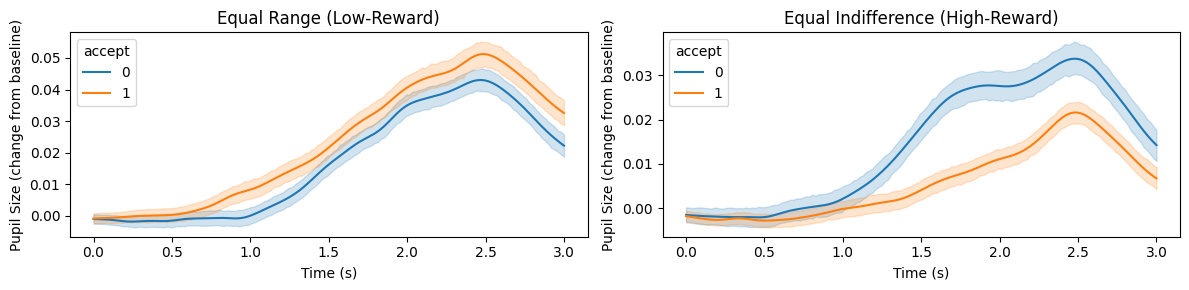

In [9]:
# Create subplot with 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3))

# Equal Range plot
sns.lineplot(data=data.query("condition == 'equalRange'"), 
            x='timebin', y='ps_preprocessed', hue='accept', ax=ax1)
ax1.set_title('Equal Range (Low-Reward)')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Pupil Size (change from baseline)')

# Equal Indifference plot  
sns.lineplot(data=data.query("condition == 'equalIndifference'"), 
            x='timebin', y='ps_preprocessed', hue='accept', ax=ax2)
ax2.set_title('Equal Indifference (High-Reward)') 
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Pupil Size (change from baseline)')

plt.tight_layout()
plt.show()


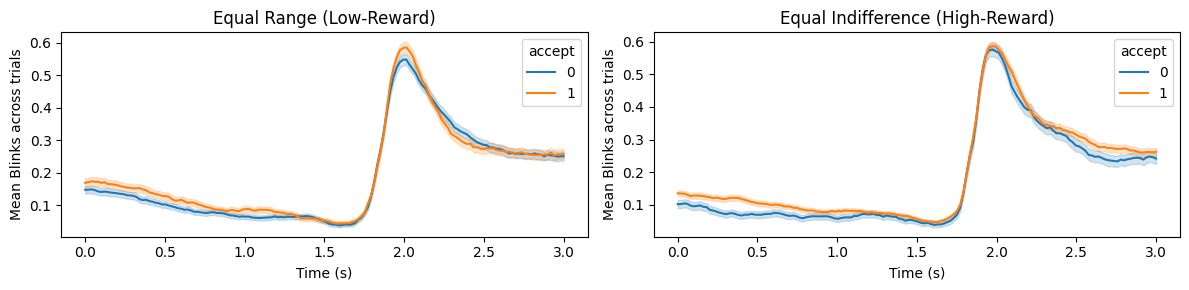

In [46]:
# Create subplot with 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3))

# Equal Range plot
sns.lineplot(data=data.query("condition == 'equalRange'"), 
            x='timebin', y='blink', hue='accept', ax=ax1)
ax1.set_title('Equal Range (Low-Reward)')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Mean Blinks across trials')

# Equal Indifference plot  
sns.lineplot(data=data.query("condition == 'equalIndifference'"), 
            x='timebin', y='blink', hue='accept', ax=ax2)
ax2.set_title('Equal Indifference (High-Reward)') 
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Mean Blinks across trials')

plt.tight_layout()
plt.show()

In [10]:
%%R -i data
library(mgcv)
library(lme4)
library(lmerTest)

/Users/gustxsr/Documents/Stanford/PoldrackLab/github/riskyneuroarousal/.venv/lib/python3.12/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "outofbounds". Fall back to string conversion. The error is: Series can only be of one type, or None (and here we have <class 'bool'> and <class 'int'>). If happening with a pandas DataFrame the method infer_objects() will normalize data types before conversion.
  warnings.warn('Error while trying to convert '


Loading required package: nlme
This is mgcv 1.9-1. For overview type 'help("mgcv-package")'.
Loading required package: Matrix

Attaching package: ‘lme4’

The following object is masked from ‘package:nlme’:

    lmList


Attaching package: ‘lmerTest’

The following object is masked from ‘package:lme4’:

    lmer

The following object is masked from ‘package:stats’:

    step



In [40]:
%%R
# loop through timebins
timebins <- c()
coefficient_pvalues <- c()
coefficient_name <- c()
coefficient_estimate <- c()
for (tb in unique(data$timebin)) {
    # for each timebin, run a linear mixed effects model of ps_preprocessed predicted by accept*condition + blink*condition + (sub|1)
    model = lmer(ps_preprocessed ~ accept*condition + blink*condition + (1|sub), data=data[data$timebin == tb, ])
    # model = lmer(ps_preprocessed ~ accept*condition +loss*condition + gain*condition + blink*condition + (1|sub), data=data[data$timebin == tb, ])
    # save the coefficients and pvalues in a list
    fixed_effects <- summary(model)$coefficients
    # Loop through fixed effects
    for (i in 1:nrow(fixed_effects)) {
        effect_name <- rownames(fixed_effects)[i]  # Name of the fixed effect
        estimate <- fixed_effects[i, "Estimate"]  # Estimate of the fixed effect
        p_value <- fixed_effects[i, "Pr(>|t|)"]   # p-value of the fixed effect
        coefficient_pvalues <- c(coefficient_pvalues, p_value)
        coefficient_name <- c(coefficient_name, effect_name)
        coefficient_estimate <- c(coefficient_estimate, estimate)
        timebins <- c(timebins, tb)
    }
}

In [50]:
%%R
# loop through timebins FOR ACCEPT
timebins <- c()
coefficient_pvalues <- c()
coefficient_name <- c()
coefficient_estimate <- c()
sub_list <- c()
for (tb in unique(data$timebin)) {
    # skip tb lower than 1.3 and higher than 1.5
    if (tb < 1.3 | tb > 1.5) {
        next
    }
    # loop through each sub
    for (sub in unique(data$sub)) {
        # for each timebin, run a linear mixed effects model of ps_preprocessed predicted by accept*condition + blink*condition + (sub|1)
        model = lm(ps_preprocessed ~ accept + blink, data=data[data$timebin == tb & data$sub == sub, ])
        # save the coefficients and pvalues in a list
        fixed_effects <- summary(model)$coefficients
        # Loop through fixed effects
        for (i in 1:nrow(fixed_effects)) {
            effect_name <- rownames(fixed_effects)[i]  # Name of the fixed effect
            estimate <- fixed_effects[i, "Estimate"]  # Estimate of the fixed effect
            p_value <- fixed_effects[i, "Pr(>|t|)"]   # p-value of the fixed effect
            coefficient_pvalues <- c(coefficient_pvalues, p_value)
            coefficient_name <- c(coefficient_name, effect_name)
            coefficient_estimate <- c(coefficient_estimate, estimate)
            timebins <- c(timebins, tb)
            sub_list <- c(sub_list, sub)
        }
    }
}


In [89]:
%%R
# loop through timebins FOR ACCEPT
timebins <- c()
coefficient_pvalues <- c()
coefficient_name <- c()
coefficient_estimate <- c()
sub_list <- c()
for (tb in unique(data$timebin)) {
    # skip tb lower than 1.3 and higher than 1.5
    if (tb < 1.3 | tb > 1.5) {
        next
    }
    # loop through each sub
    for (sub in unique(data$sub)) {
        # for each timebin, run a linear mixed effects model of ps_preprocessed predicted by accept*condition + blink*condition + (sub|1)
        model = lm(ps_preprocessed ~ gain + loss + blink, data=data[data$timebin == tb & data$sub == sub, ])
        # save the coefficients and pvalues in a list
        fixed_effects <- summary(model)$coefficients
        # Loop through fixed effects
        for (i in 1:nrow(fixed_effects)) {
            effect_name <- rownames(fixed_effects)[i]  # Name of the fixed effect
            estimate <- fixed_effects[i, "Estimate"]  # Estimate of the fixed effect
            p_value <- fixed_effects[i, "Pr(>|t|)"]   # p-value of the fixed effect
            coefficient_pvalues <- c(coefficient_pvalues, p_value)
            coefficient_name <- c(coefficient_name, effect_name)
            coefficient_estimate <- c(coefficient_estimate, estimate)
            timebins <- c(timebins, tb)
            sub_list <- c(sub_list, sub)
        }
    }
}


In [90]:
%%R
# put them into a dataframe
coefficient_df <- data.frame(timebin = timebins, 
                            name = coefficient_name, 
                            estimate = coefficient_estimate, 
                            pvalue = coefficient_pvalues,
                            sub = sub_list)


In [91]:
%%R -o coefficient_df
str(coefficient_df)

'data.frame':	2114 obs. of  5 variables:
 $ timebin : num  1.31 1.31 1.31 1.31 1.31 ...
 $ name    : chr  "(Intercept)" "gain" "loss" "blinkTRUE" ...
 $ estimate: num  0.035947 -0.000923 0.001417 0.079065 0.006007 ...
 $ pvalue  : num  0.228 0.573 0.379 0.19 0.652 ...
 $ sub     : int  6 6 6 6 43 43 43 62 62 62 ...


In [93]:
gain_coeff = coefficient_df.query("name ==  'gain'").groupby('sub')['estimate'].mean().reset_index()
loss_coeff = coefficient_df.query("name ==  'loss'").groupby('sub')['estimate'].mean().reset_index()

<Axes: xlabel='name', ylabel='estimate'>

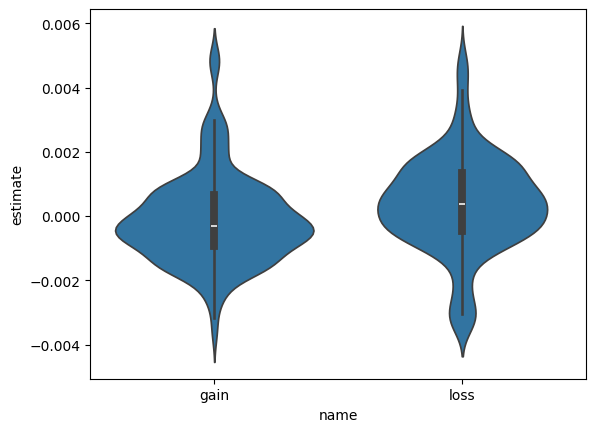

In [98]:
sns.violinplot(data=coefficient_df.query("name == 'gain' | name == 'loss'"), x='name', y='estimate')

In [57]:
accept_coeff = coefficient_df.query("name ==  'accept'").groupby('sub')['estimate'].mean().reset_index()

In [63]:
# get the condition for each unique sub
sub_cond = behav[["sub", "condition"]].drop_duplicates().reset_index(drop=True)
accept_coeff = accept_coeff.merge(sub_cond, on='sub')

In [69]:
import scipy.stats as stats
# run ttest_ind on the estimate column
stats.ttest_ind(accept_coeff.query("condition == 'equalRange'")['estimate'].values,
                accept_coeff.query("condition == 'equalIndifference'")['estimate'].values)

TtestResult(statistic=np.float64(2.915286568926223), pvalue=np.float64(0.005231962759901823), df=np.float64(52.0))

In [71]:
# Get DDM fits
all_params_fit = pd.read_csv("../../data/ddm_fits.csv")

In [111]:
corr = all_params_fit.query("param_name == 'z'")[['sub', 'mean']].merge(accept_coeff, on='sub')

In [112]:
prob_accept = behav.groupby('sub')['accept'].mean().reset_index()
corr = corr.merge(prob_accept, on='sub')

In [113]:
corr

,sub,mean,estimate,condition,accept
0,5,0.578237,-0.000730,equalIndifference,0.570312
1,45,0.593072,-0.011016,equalIndifference,0.648438
2,10,0.547488,-0.016251,equalRange,0.539062
3,36,0.614224,-0.040857,equalRange,0.632812
4,63,0.566596,-0.044590,equalIndifference,0.812500
5,54,0.483781,-0.001664,equalRange,0.519531
6,80,0.552199,-0.004099,equalRange,0.570312
7,33,0.579376,-0.025419,equalIndifference,0.699219
8,66,0.475504,-0.008874,equalRange,0.390625
9,99,0.565902,-0.032117,equalIndifference,0.691406


In [114]:
import scipy.stats as stats
print(stats.pearsonr(corr['mean'], corr['estimate']))
print(stats.pearsonr(corr['mean'], corr['accept']))
print(stats.pearsonr(corr['accept'], corr['estimate']))


PearsonRResult(statistic=np.float64(-0.48666418820210355), pvalue=np.float64(0.00019038843671797463))
PearsonRResult(statistic=np.float64(0.6712845507850873), pvalue=np.float64(2.768561461015642e-08))
PearsonRResult(statistic=np.float64(-0.7102353441310947), pvalue=np.float64(1.8009391317616286e-09))


In [ ]:
# I guess we can ask, how much does that individual estimate can be predicted by the different variables in the DDM?


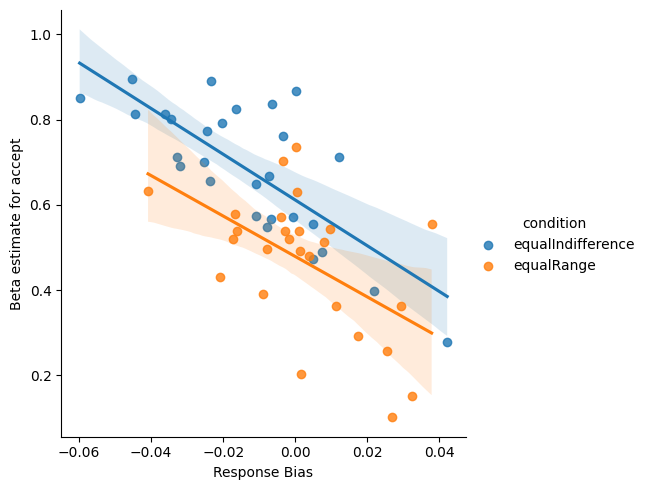

In [116]:
# sns.scatterplot(data=corr, x='mean', y='estimate', hue='condition')
# plot regression line per condition
sns.lmplot(data=corr, x='estimate', y='accept', hue='condition')
# rename x axis to Response Bias
plt.xlabel("Response Bias")
plt.ylabel("Beta estimate for accept")
plt.show()
# Response bias of 0.5 is indifferent. 
# 

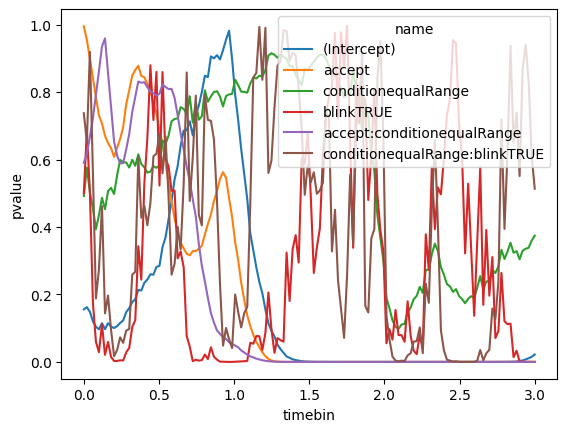

In [43]:
sns.lineplot(data=coefficient_df, x='timebin', y='pvalue', hue='name')
plt.show()

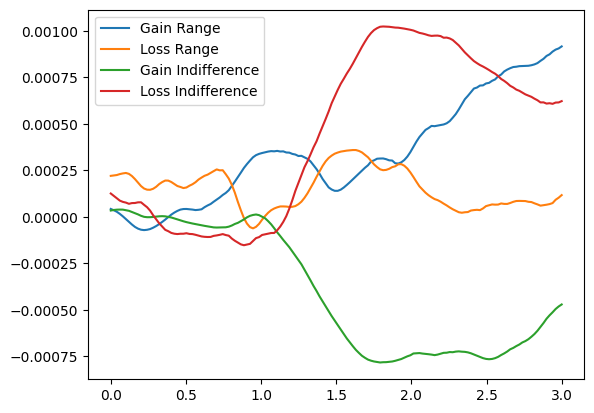

In [28]:
timebins = coefficient_df.query("name == 'gain'")['timebin'].values
gain_indiff = coefficient_df.query("name == 'gain'")['estimate'].values
loss_indiff = coefficient_df.query("name == 'loss'")['estimate'].values
gain_range = coefficient_df.query("name == 'conditionequalRange:gain'")['estimate'].values + gain_indiff
loss_range = coefficient_df.query("name == 'loss:conditionequalRange'")['estimate'].values + loss_indiff

plt.plot(timebins, gain_range, label='Gain Range')
plt.plot(timebins, loss_range, label='Loss Range')
plt.plot(timebins, gain_indiff, label='Gain Indifference')
plt.plot(timebins, loss_indiff, label='Loss Indifference')
plt.legend()
plt.show()

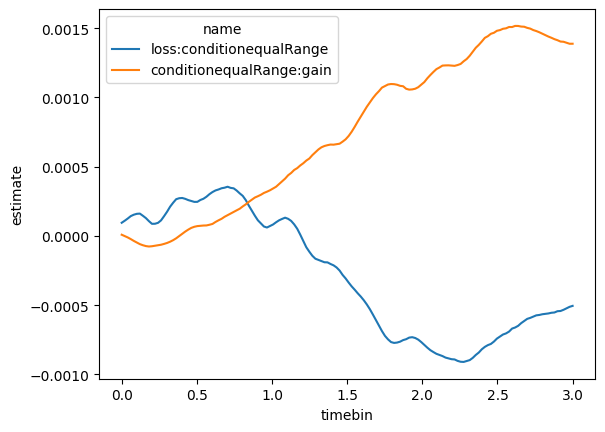

In [24]:
sns.lineplot(data=coefficient_df.query("name == 'conditionequalRange:gain' | name == 'loss:conditionequalRange'"), x='timebin', y='estimate', hue='name')
plt.show()

In [43]:
accept_LR = coefficient_df.query("name == 'accept'")['estimate'].values + coefficient_df.query("name == 'accept:conditionequalRange'")['estimate'].values
accept_HR = coefficient_df.query("name == 'accept'")['estimate'].values
timebins = coefficient_df.query("name == 'accept'")['timebin'].values

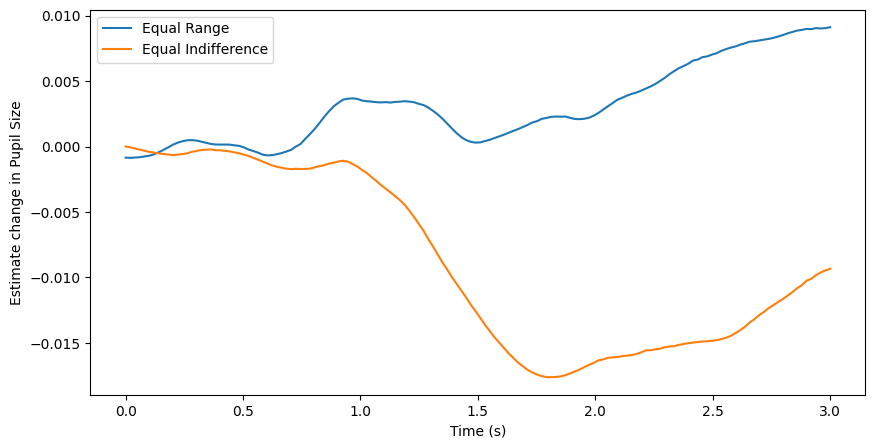

In [45]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(timebins, accept_LR, label='Equal Range')
ax.plot(timebins, accept_HR, label='Equal Indifference')
ax.legend()
ax.set_xlabel('Time (s)')
ax.set_ylabel('Estimate change in Pupil Size')
plt.show()


In [47]:
accept_LR_pvalue = coefficient_df.query("name == 'accept:conditionequalRange'")['pvalue'].values
accept_HR_pvalue = coefficient_df.query("name == 'accept'")['pvalue'].values
timebins = coefficient_df.query("name == 'accept'")['timebin'].values

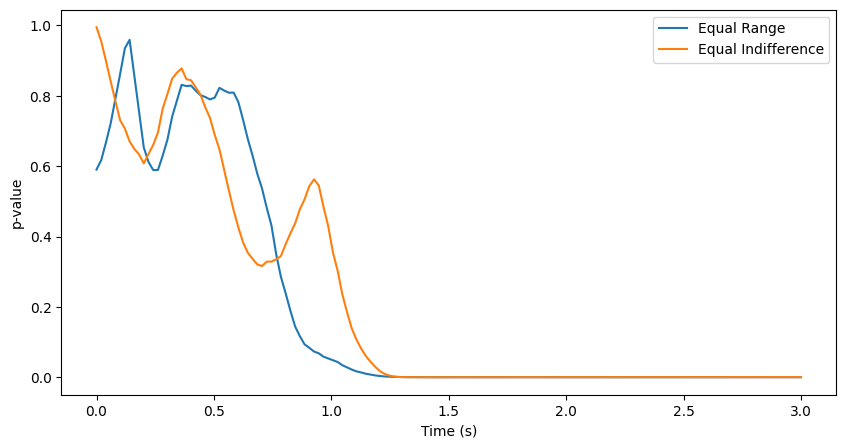

In [48]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(timebins, accept_LR_pvalue, label='Equal Range')
ax.plot(timebins, accept_HR_pvalue, label='Equal Indifference')
ax.legend()
ax.set_xlabel('Time (s)')
ax.set_ylabel('p-value')
plt.show()

In [37]:
pupil_trial_response = data.query("timebin > 1.25 & timebin <= 1.5").groupby(['sub', 'trial', 'condition', 'accept', 'response_int', 'RT'])['ps_preprocessed'].mean().reset_index()

,sub,trial,condition,accept,response_int,RT,ps_preprocessed
0,3,2,equalIndifference,1,4.0,1.041,-0.079474
1,3,3,equalIndifference,1,3.0,2.803,0.029377
2,3,4,equalIndifference,1,4.0,0.936,-0.061983
3,3,5,equalIndifference,1,4.0,1.142,-0.082258
4,3,6,equalIndifference,1,4.0,1.145,-0.161906
...,...,...,...,...,...,...,...
13656,124,252,equalRange,0,1.0,1.235,0.078126
13657,124,253,equalRange,0,1.0,1.236,0.013607
13658,124,254,equalRange,0,1.0,1.030,-0.001887
13659,124,255,equalRange,0,1.0,1.029,0.002850


<Axes: xlabel='condition', ylabel='ps_preprocessed'>

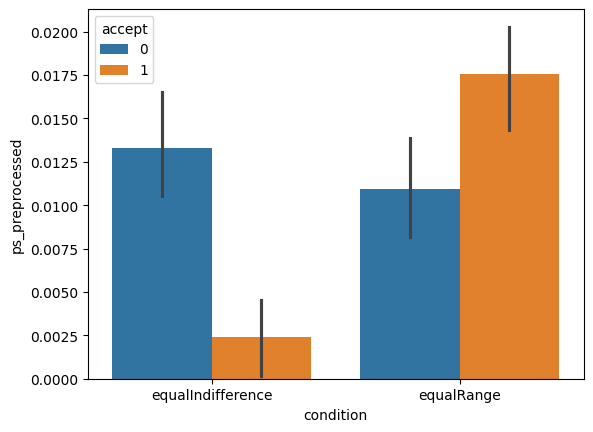

In [39]:
sns.barplot(data=pupil_trial_response, x='condition', y='ps_preprocessed', hue='accept')

In [35]:
all_params_fit

,param_name,mean,std,2.5q,25q,50q,75q,97.5q,mc err,sub,model_ID,condition
0,a,1.133174,0.089409,0.977751,1.070338,1.125048,1.186513,1.330354,0.005045,5,1,equalIndifference
1,z,0.578237,0.021392,0.536227,0.563991,0.578658,0.592695,0.618470,0.000590,5,1,equalIndifference
2,t,0.827565,0.029746,0.757339,0.812235,0.833576,0.848598,0.872242,0.001595,5,1,equalIndifference
3,theta,0.254534,0.068042,0.121394,0.209770,0.255331,0.299840,0.387720,0.003433,5,1,equalIndifference
4,v_Intercept,0.654338,0.301838,0.105846,0.439031,0.651854,0.865437,1.252172,0.022340,5,1,equalIndifference
...,...,...,...,...,...,...,...,...,...,...,...,...
373,t,0.547312,0.065196,0.421694,0.501535,0.549268,0.595346,0.668995,0.004880,60,1,equalRange
374,theta,0.809657,0.081369,0.595379,0.770561,0.825508,0.867382,0.920770,0.006163,60,1,equalRange
375,v_Intercept,-1.317030,0.269916,-1.828701,-1.506000,-1.317558,-1.131609,-0.792999,0.018373,60,1,equalRange
376,v_gain,0.238002,0.012723,0.211019,0.229851,0.238595,0.246828,0.261493,0.000755,60,1,equalRange


<Axes: xlabel='condition', ylabel='proportion'>

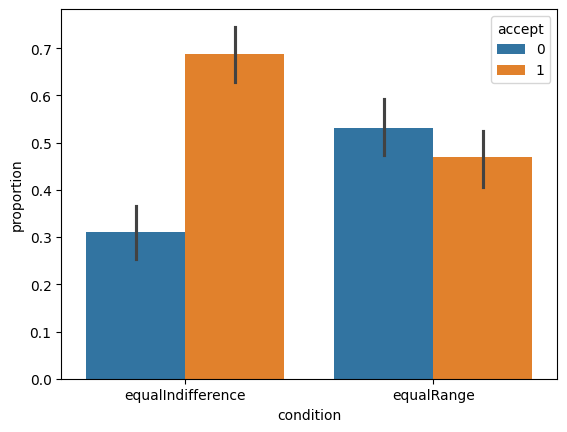

In [75]:
# percentage of total for each response_int
d = pupil_trial_response.groupby(["sub", "condition"])["accept"].value_counts(normalize=True).rename('proportion').reset_index()
sns.barplot(data=d, x='condition', y='proportion', hue='accept')
# avg_responses = behavior_df.groupby(['subj_ID', 'condition'])['uncertainty'].value_counts(normalize=True).rename('proportion').reset_index()

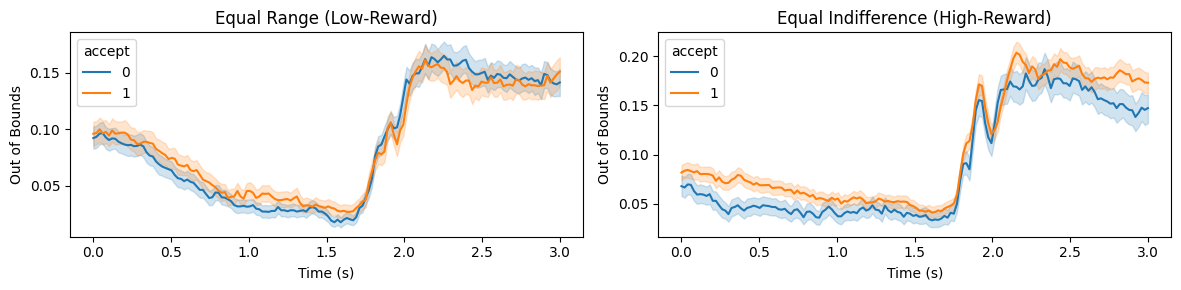

In [17]:
# Create subplot with 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3))

# Equal Range plot
sns.lineplot(data=data.query("condition == 'equalRange'"), 
            x='timebin', y='outofbounds', hue='accept', ax=ax1)
ax1.set_title('Equal Range (Low-Reward)')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Out of Bounds')

# Equal Indifference plot  
sns.lineplot(data=data.query("condition == 'equalIndifference'"), 
            x='timebin', y='outofbounds', hue='accept', ax=ax2)
ax2.set_title('Equal Indifference (High-Reward)') 
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Out of Bounds')

plt.tight_layout()
plt.show()

In [30]:
print("Equal Indifference (or High-Payoff) condition")
behav.query("condition == 'equalIndifference'")['accept'].value_counts() / len(behav.query("condition == 'equalIndifference'"))

Equal Indifference (or High-Payoff) condition


accept
1    0.65285
0    0.34715
Name: count, dtype: float64

#### What do we see?
It could be the case, that noradrenergic system (as indexed by pupil dilation) is shaping the pre-evaluation bias. 

In [13]:
X.astype(float)
#why nan in outofbounds???

,response_int_1.0,response_int_2.0,response_int_3.0,response_int_4.0,condition_equalIndifference,condition_equalRange,blink,outofbounds
0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
150,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
300,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
450,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
600,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...
2087100,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2087250,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2087400,1.0,0.0,0.0,0.0,0.0,1.0,1.0,NaN
2087550,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0


In [14]:
# for each timebin, we will do regression of ps_preprocessed, predicted by response_int, condition, blink and outofbounds
# Create a list to store regression results for each timebin
regression_results = []

# Get unique timebins
timebins = data['timebin'].unique()

# For each timebin, fit a regression model
for tb in timebins:
    # Get data for this timebin
    tb_data = data[data['timebin'] == tb].copy()
    
    # Create dummy variables for categorical predictors
    tb_data = pd.get_dummies(tb_data, columns=['response_int', 'condition'])
    
    # Prepare X (predictors) and y (target)
    X = tb_data[[col for col in tb_data.columns if col.startswith(('response_int_', 'condition_'))] + 
                ['blink', 'outofbounds']]
    y = tb_data['ps_preprocessed']
    
    # Fit linear regression
    model = sm.OLS(y, sm.add_constant(X.astype(float))).fit()
    
    # Store results
    results = pd.DataFrame({
        'timebin': tb,
        'predictor': model.params.index,
        'coefficient': model.params.values,
        'pvalue': model.pvalues.values,
        'rsquared': model.rsquared
    })
    
    regression_results.append(results)

# Combine all results
regression_df = pd.concat(regression_results, ignore_index=True)

# Plot regression coefficients over time for each predictor
plt.figure(figsize=(12, 6))
for predictor in regression_df['predictor'].unique():
    if predictor != 'const':  # Skip intercept
        pred_data = regression_df[regression_df['predictor'] == predictor]
        plt.plot(pred_data['timebin'], pred_data['coefficient'], label=predictor)

plt.axhline(y=0, color='k', linestyle='--', alpha=0.3)
plt.xlabel('Time (s)')
plt.ylabel('Coefficient')
plt.title('Regression Coefficients Over Time')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


MissingDataError: exog contains inf or nans

<Axes: xlabel='timebin', ylabel='ps_preprocessed'>

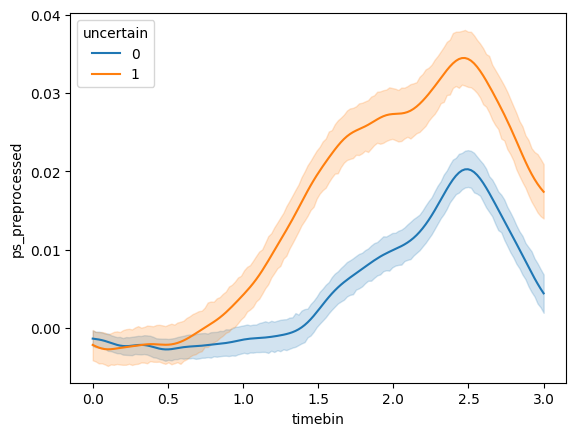

### Regression of timebins
To determine the impact of pupil size based on the stimulus shown? or on their responses?
Ugh how did they make this regression and also what would we expect to find from this that would be beneficial for the paper-esque. 

In [101]:
# for each sub, trial pair, compute the mean ps_preprocessed for timebins between 2 and 2.5
mean_pupil = data.query("timebin >= 1 & timebin < 2").groupby(['sub', 'trial'])['ps_preprocessed'].mean().reset_index()

In [102]:
mean_pupil = pd.merge(mean_pupil, behav, on=['sub', 'trial'])

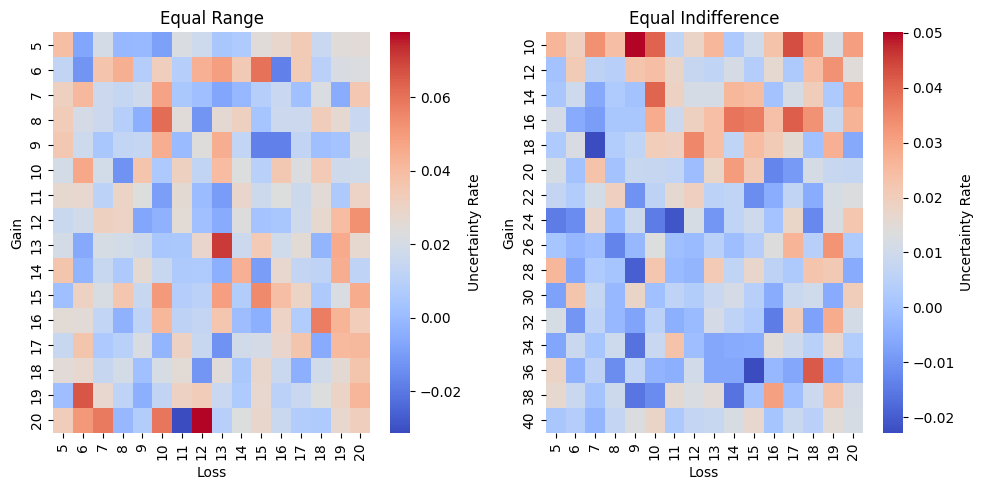

In [103]:
# Two figures: Uncertainty rate per condition
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
hmap_data = mean_pupil.query("condition == 'equalRange'").groupby(['gain', 'loss'])['ps_preprocessed'].mean().unstack()
sns.heatmap(hmap_data, cmap='coolwarm', cbar_kws={'label': 'Uncertainty Rate'}, ax = axs[0])
axs[0].set_title("Equal Range")
axs[0].set_xlabel("Loss")
axs[0].set_ylabel("Gain")

hmap_data = mean_pupil.query("condition == 'equalIndifference'").groupby(['gain', 'loss'])['ps_preprocessed'].mean().unstack()
sns.heatmap(hmap_data, cmap='coolwarm', cbar_kws={'label': 'Uncertainty Rate'}, ax = axs[1])
axs[1].set_title("Equal Indifference")
axs[1].set_xlabel("Loss")
axs[1].set_ylabel("Gain")
plt.tight_layout()
plt.show()

In [92]:
# for each sub, create a ps_preprocessed_bin for 4 bins
mean_pupil['ps_bins'] = mean_pupil.groupby(['sub'])['ps_preprocessed'].transform(
                     lambda x: pd.qcut(x, 4, labels=range(1, 5)))

In [94]:
# change dtype of ps_bins to int
mean_pupil['ps_bins'] = mean_pupil['ps_bins'].astype(int)

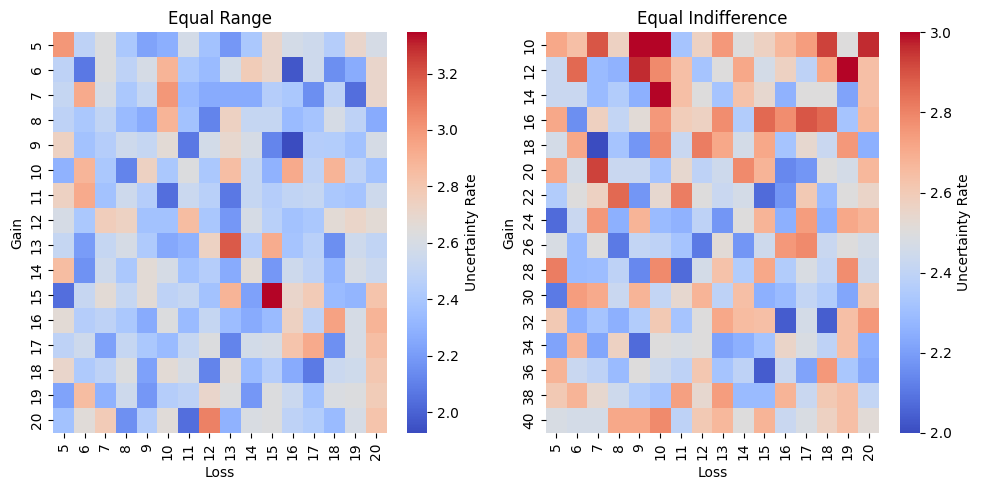

In [95]:
# Two figures: Uncertainty rate per condition
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
hmap_data = mean_pupil.query("condition == 'equalRange'").groupby(['gain', 'loss'])['ps_bins'].mean().unstack()
sns.heatmap(hmap_data, cmap='coolwarm', cbar_kws={'label': 'Uncertainty Rate'}, ax = axs[0])
axs[0].set_title("Equal Range")
axs[0].set_xlabel("Loss")
axs[0].set_ylabel("Gain")

hmap_data = mean_pupil.query("condition == 'equalIndifference'").groupby(['gain', 'loss'])['ps_bins'].mean().unstack()
sns.heatmap(hmap_data, cmap='coolwarm', cbar_kws={'label': 'Uncertainty Rate'}, ax = axs[1])
axs[1].set_title("Equal Indifference")
axs[1].set_xlabel("Loss")
axs[1].set_ylabel("Gain")
plt.tight_layout()
plt.show()

Text(50.722222222222214, 0.5, 'Gain')

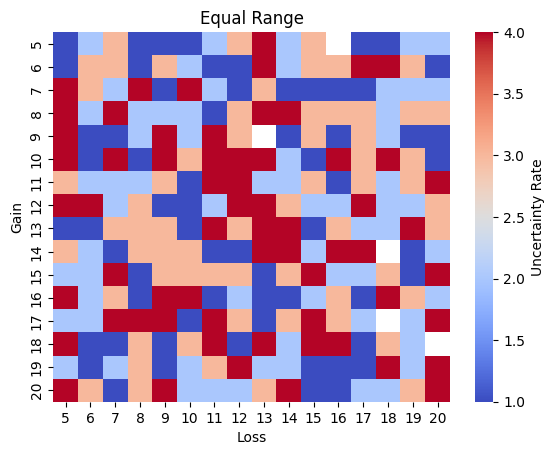

In [97]:
hmap_data = mean_pupil.query("sub == 4").groupby(['gain', 'loss'])['ps_bins'].mean().unstack()
sns.heatmap(hmap_data, cmap='coolwarm', cbar_kws={'label': 'Uncertainty Rate'})
plt.title("Equal Range")
plt.xlabel("Loss")
plt.ylabel("Gain")

Text(50.722222222222214, 0.5, 'Gain')

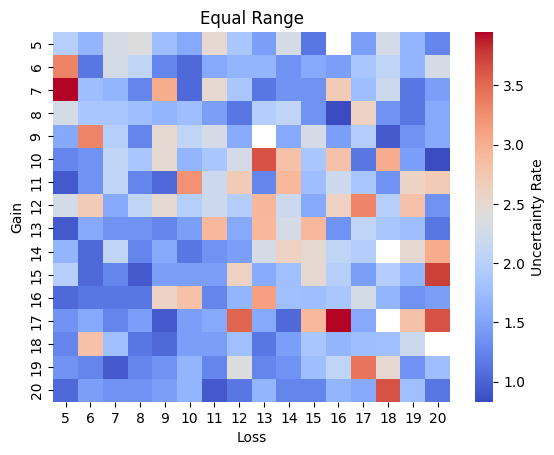

In [98]:
hmap_data = mean_pupil.query("sub == 4").groupby(['gain', 'loss'])['RT'].mean().unstack()
sns.heatmap(hmap_data, cmap='coolwarm', cbar_kws={'label': 'Uncertainty Rate'})
plt.title("Equal Range")
plt.xlabel("Loss")
plt.ylabel("Gain")

In [59]:
%%R -i mean_pupil

library(lme4)
library(lmerTest)

In [64]:
%%R
# response_int as factor
mean_pupil$response_int = as.factor(mean_pupil$response_int)
# Fit a linear mixed effects model

model = lmer(ps_preprocessed ~ condition*RT + condition*response_int + (1|sub), data=mean_pupil)

In [65]:
%%R 
summary(model)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]


Formula: ps_preprocessed ~ condition * RT + condition * response_int +  
    (1 | sub)
   Data: mean_pupil

REML criterion at convergence: -30080.5

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.7171 -0.5675 -0.0721  0.4877 10.1167 

Random effects:
 Groups   Name        Variance  Std.Dev.
 sub      (Intercept) 0.0008152 0.02855 
 Residual             0.0066108 0.08131 
Number of obs: 13919, groups:  sub, 55

Fixed effects:
                                    Estimate Std. Error         df t value
(Intercept)                       -4.086e-03  6.662e-03  1.144e+02  -0.613
conditionequalRange               -1.607e-02  9.381e-03  1.081e+02  -1.713
RT                                 1.749e-02  1.960e-03  1.379e+04   8.926
response_int2                     -3.322e-03  3.632e-03  1.389e+04  -0.915
response_int3                     -7.671e-03  3.286e-03  1.390e+04  -2.335
response_int4                     -2.157e-02  2.871e-03  1.391e+04  -7.514
conditionequalRange:RT       

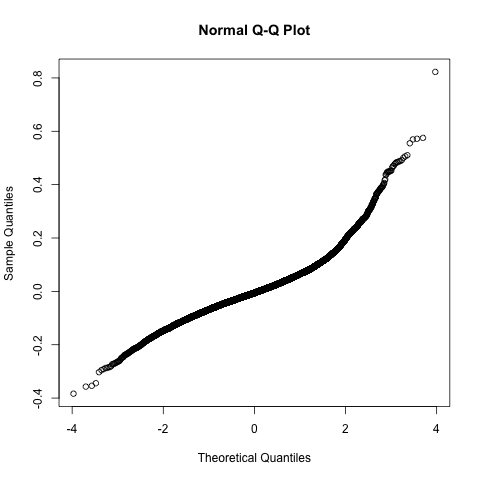

In [68]:
%%R
# look at residuals of model
plot(model)
# # look at model fit
qqnorm(residuals(model))

In [ ]:
# you might just want to know the difference between the peak throgh timne?
# bin them then  include them into the ddm model. 